![example](images/director_shot.jpeg)

# Microsoft Movie Studio Analysis

**Authors:** Angela Loyola
***

## Overview

This project researches Box Offices movies and their different characteristics like genre, ratings, and release date. It seeks to inform Microsoft's strategic planning as they enter the movie production space by creating their own movies for distribution. Descriptive analysis shows Family movies released in December or June have a high potential to drive a large Domestic Gross. Microsoft can use this analysis to develop a market entry strategy that has a high return on investment. 


## Business Problem

Microsoft is entering a competitive space with no prior experience in movie production. To break into the space, Microsoft must know what movie genres to produce but also when is the best time to distribute. For this analysis, "best" is being defined in terms of revenue because Microsoft needs to prioritize their profits when assessing if this is a viable, long-term business for them. 

Using Data from IMDB, the Movie Database, and Box Office Mojo,  I analyzed the relatonship between genres, ratings, and release dates to predict where Microsoft can better allocate its resources to increase the probability of success. 

## Data Understanding

For this analysis I will be pulling from three different databases to analyze relationships between different variables. The target variable is domestic gross from Box Office Mojo, but in order to compare its relationship to other movie characteristics (ratings, genre, release date), I need to merge DBs on movie title which exists in all three of them. 

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import datetime
import calendar
%matplotlib inline

In [2]:
#Loading DBs
movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
conn = sqlite3.Connection('zippedData/im.db')
tmdb = pd.read_csv('zippedData/tmdb.movies.csv.gz')

In [3]:
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [4]:
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


## Box Office Mojo Data Set  

This DB includes data from 2010 - 2018 on domestic and foreign gross for over 3 thousand movies, including their production studio. 

There are 1.3K missing values for foreign gross, but only 28 missing values for domestic gross. There is also 5 titles that have missing studios. 

In [5]:
movie_gross.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [6]:
movie_gross['year'].value_counts()

2015    450
2016    436
2012    400
2011    399
2014    395
2013    350
2010    328
2017    321
2018    308
Name: year, dtype: int64

In [7]:
missing_values = movie_gross.isnull().sum()
missing_values

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

## IMDB Data Set 

This SQL IMDB database has 8 relational databases. For this analysis, the focus will be on 2: movie basics and movie ratings. After joining these two tables, we will have access to movie titles, start year, run time, genres, average rating and number of votes. There is some missing values in the runtime and genre columns.

In [8]:
q1 = """
select *
from movie_basics
join movie_ratings
using (movie_id);
"""

In [9]:
##Load Movie Basics
imdb = pd.read_sql(q1, conn)

In [10]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [11]:
imdb.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [12]:
imdb_missing_values = imdb.isnull().sum()
imdb_missing_values

movie_id              0
primary_title         0
original_title        0
start_year            0
runtime_minutes    7620
genres              804
averagerating         0
numvotes              0
dtype: int64

### TMDB Data Set

The Movie Data Base has movie titles and release date with month and day along with other information like language and popularity. There is no missing values. 

In [13]:
tmdb.drop(columns = "Unnamed: 0", inplace = True)

In [14]:
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          26517 non-null  object 
 1   id                 26517 non-null  int64  
 2   original_language  26517 non-null  object 
 3   original_title     26517 non-null  object 
 4   popularity         26517 non-null  float64
 5   release_date       26517 non-null  object 
 6   title              26517 non-null  object 
 7   vote_average       26517 non-null  float64
 8   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 1.8+ MB


In [15]:
tmdb_missing = tmdb.isnull().sum()
tmdb_missing

genre_ids            0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
title                0
vote_average         0
vote_count           0
dtype: int64

In [16]:
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


## Data Preparation

Since both the Mojo Data Set and IMDB have missing values, this needed to be addressed before the analysis.

For box office mojo, since the majority of misisng values were for Foreign Gross (not the focus of the analysis), this column was dropped from the database. 

For IMDB, since the majority of the missing values were for runtime (not used in this analysis), they were replaced with 0, to avoid dropping the entire row. 

After these adjustments, all null values were dropped since it involved ratings or gross which were a focus of the analysis

### Addressing Missing Values in Two DB

For the Movie Gross Data Set, since we will focus on Domestic Movie Gross, I will drop all movie titles with missing values since the majority is Foreign Gross. 

For IMDB, I will also drop missing values since it is only 804 values out of over 73K. 

In [17]:
movie_gross = movie_gross.drop(columns = 'foreign_gross')

In [19]:
movie_gross = movie_gross.dropna()

In [20]:
##Checking that there is no missing values
missing_values = movie_gross.isnull().sum()
missing_values

title             0
studio            0
domestic_gross    0
year              0
dtype: int64

In [21]:
imdb['runtime_minutes'] = imdb['runtime_minutes'].fillna(0)

In [22]:
imdb.isnull().sum()

movie_id             0
primary_title        0
original_title       0
start_year           0
runtime_minutes      0
genres             804
averagerating        0
numvotes             0
dtype: int64

In [23]:
imdb = imdb.dropna()

In [24]:
imdb.isnull().sum()

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
averagerating      0
numvotes           0
dtype: int64

### Data Cleaning and Creating New Databases

To perfom the analysis, I will create two DBs: 
1. DB1: movie title, genre, average rating, domestic gross
2. DB2: movie title, release date, domestic gross

Before merging, some data cleaning was necessary as some movie titles in the BOMD data have the year following the title (ex: Alice in Wonderland (2010)). This could prevent a match on the IMDB data. 

Since there is significantly less BOMD data avaliable, I've used a left merge to only match on movies for which domestic gross is available. 

After the merge, there were very few null values in the genre column. These values were dropped since they can't be estimated. 

The second merge will create a separate DB to link domestic gross and release dates. Since there was no missing data in the Movie Database, there is no data cleaning necessary before the merge. The only additional action was to drop null values which would appear if there was no match. 

In [25]:
##Creating DB1

In [26]:
import re
def remove_year (string): 
    new = re.sub("\(.*?\)","", string)
    new = new.strip()
    return new 

In [27]:
movie_gross['title'] = movie_gross['title'].map(remove_year)

In [28]:
db1 = pd.merge(movie_gross, imdb, left_on = "title", right_on = "primary_title", how = 'left')

In [29]:
db1['genres'].isna().value_counts()

False    3517
True      512
Name: genres, dtype: int64

In [30]:
db1= db1.dropna()

In [31]:
db1 = db1[['title', 'domestic_gross', 'genres', 'averagerating']]

In [32]:
db1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3517 entries, 0 to 4028
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3517 non-null   object 
 1   domestic_gross  3517 non-null   float64
 2   genres          3517 non-null   object 
 3   averagerating   3517 non-null   float64
dtypes: float64(2), object(2)
memory usage: 137.4+ KB


In [33]:
## Creating DB2

In [34]:
release_vote = tmdb[['title', 'release_date', 'vote_average']]

In [35]:
release_vote.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         26517 non-null  object 
 1   release_date  26517 non-null  object 
 2   vote_average  26517 non-null  float64
dtypes: float64(1), object(2)
memory usage: 621.6+ KB


In [36]:
db2 = pd.merge(movie_gross, release_vote, on = 'title', how = 'left')

In [37]:
db2['release_date'].isna().value_counts()

False    3058
True      829
Name: release_date, dtype: int64

In [38]:
db2 = db2[['title', 'domestic_gross', 'release_date']]

In [39]:
db2 = db2.dropna()

In [40]:
db2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3058 entries, 0 to 3886
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3058 non-null   object 
 1   domestic_gross  3058 non-null   float64
 2   release_date    3058 non-null   object 
dtypes: float64(1), object(2)
memory usage: 95.6+ KB


## Data Modeling
<!-- Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
*** -->



### Top Genres by Average Profit

Since there are many Genres associated with each movie, I will be selecting only the first genre listed to be able to give a broader recommendation. 

This analysis seeks to determine which genre has the highest average gross using mean as a measure of central tendancy.

In [46]:
db1['genre_agg'] = db1['genres'].str.split(',').str[0]

In [47]:
##Group By Genre and Average
db1_grouped = db1.groupby('genre_agg').mean()

In [48]:
db1_grouped = db1_grouped.sort_values(['domestic_gross'], ascending = False)

In [44]:
db1_grouped.head(5) ## Top 5

,domestic_gross,averagerating
genre_agg,,
Sci-Fi,1.375601e+08,4.566667
Family,8.406525e+07,5.881818
Adventure,6.948076e+07,6.512971
Action,5.568930e+07,6.230274
Fantasy,5.101933e+07,6.029412


<ipython-input-45-671495d3a588>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['${:,.0f}'.format(x) for x in current_values])


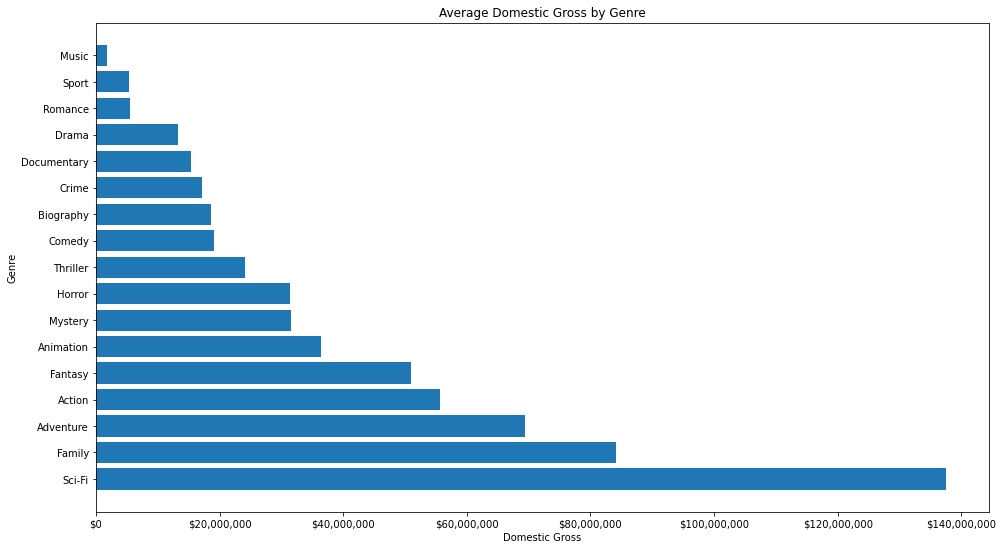

In [45]:
### Insert Chart
db1_grouped = db1_grouped.reset_index()

genre_agg = db1_grouped['genre_agg']
domestic_gross = db1_grouped['domestic_gross']

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.barh(genre_agg, domestic_gross)

plt.xlabel("Domestic Gross")
plt.ylabel("Genre")
plt.title("Average Domestic Gross by Genre")
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['${:,.0f}'.format(x) for x in current_values])
plt.show()

### Average Gross by Release Date 

This seeks to understand which release month has the highest domestic gross on average over the course of 8 years. In this case, the mean could be interpreted as the imapct of seasonality, but it could be swayed if more movies are released overall in the market during specific months. 

Yet, given the business problem, if either seasonality or external factors are the cause, this still demonstrates which month is best by considering the season but also when already existing players are active. 

In [49]:
##Convert Release Date to Date time object 
db2['release_date'] = pd.to_datetime(db2['release_date'])

In [50]:
##Pull month from release date
db2['month_of_release'] = db2['release_date'].dt.month_name()
db2['month_number'] = db2['release_date'].dt.month
db2.head()

,title,domestic_gross,release_date,month_of_release,month_number
0,Toy Story 3,415000000.0,2010-06-17,June,6
1,Alice in Wonderland,334200000.0,2010-03-05,March,3
2,Alice in Wonderland,334200000.0,2010-01-01,January,1
4,Inception,292600000.0,2010-07-16,July,7
5,Shrek Forever After,238700000.0,2010-05-16,May,5


In [51]:
##Subset for specifc cols
month_gross = db2[['month_of_release', 'domestic_gross']]

In [52]:
month_gross_grouped = month_gross.groupby('month_of_release').mean()

In [53]:
month_gross_sorted = month_gross_grouped.sort_values('domestic_gross', ascending = False)

In [54]:
month_gross_sorted = month_gross_sorted.reset_index()

In [55]:
month_gross_sorted

,month_of_release,domestic_gross
0,December,5.508934e+07
1,June,5.335044e+07
2,November,4.826384e+07
3,July,4.781313e+07
4,May,4.077257e+07
5,February,3.205069e+07
6,March,3.171231e+07
7,August,2.859844e+07
8,January,2.842796e+07
9,April,2.387628e+07


In [56]:
##Making New DB by Number for ordering in Plot
month_gross_plot = db2[['month_number', 'domestic_gross', 'month_of_release']]
month_gross_plot = month_gross_plot.groupby(['month_number', 'month_of_release']).mean()
month_gross_plot = month_gross_plot.sort_values('month_number', ascending = True)
month_gross_plot = month_gross_plot.reset_index()

In [57]:
month_gross_plot

,month_number,month_of_release,domestic_gross
0,1,January,2.842796e+07
1,2,February,3.205069e+07
2,3,March,3.171231e+07
3,4,April,2.387628e+07
4,5,May,4.077257e+07
5,6,June,5.335044e+07
6,7,July,4.781313e+07
7,8,August,2.859844e+07
8,9,September,2.223759e+07
9,10,October,1.851248e+07


<ipython-input-58-95b45bd9469c>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['${:,.0f}'.format(x) for x in current_values])


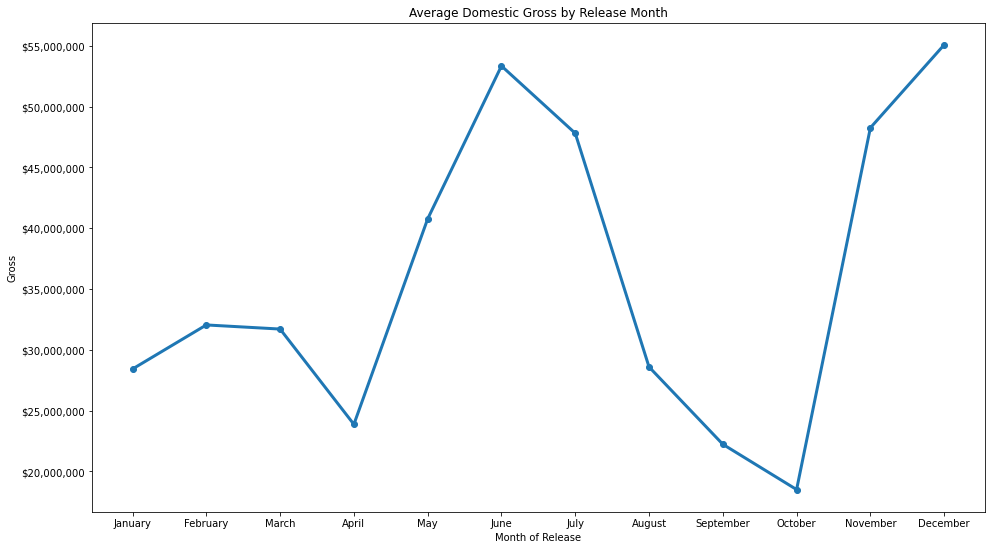

In [58]:
## ADD PLOT
month = month_gross_plot['month_of_release']
gross = month_gross_plot['domestic_gross']

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
plt.plot(month, gross, linewidth = 3, marker = "o")

plt.xlabel("Month of Release")
plt.ylabel("Gross")
plt.title("Average Domestic Gross by Release Month")
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,.0f}'.format(x) for x in current_values])
plt.show()

### Correlation between Ratings and Profit

In this section, a pearson correlation coefficient was outputted to assess the relationship between average ratings and gross.

In [59]:
rating_profit = db1[['averagerating', 'domestic_gross']]

In [60]:
corr = rating_profit['averagerating'].corr(rating_profit['domestic_gross'])

In [61]:
print('The Correlation between Average Rating and Domestic Gross is: ' , corr)

The Correlation between Average Rating and Domestic Gross is:  0.10588807172150118


<ipython-input-62-ed89fb619074>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['${:,.0f}'.format(x) for x in current_values])


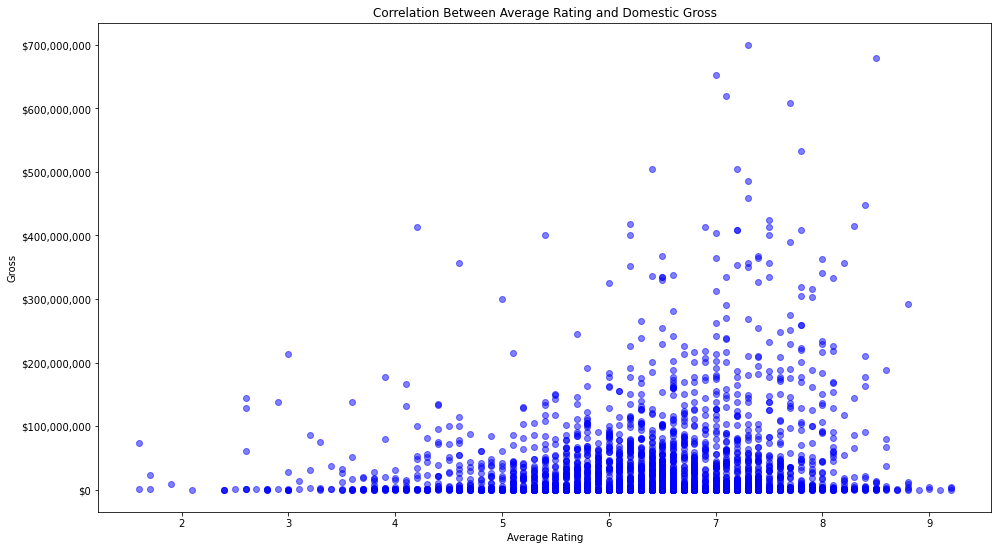

In [62]:
averagerating = rating_profit['averagerating']
domesticgross = rating_profit['domestic_gross']
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

plt.scatter(averagerating, domesticgross, c='blue', alpha=0.5)
plt.title("Correlation Between Average Rating and Domestic Gross")
plt.xlabel("Average Rating")
plt.ylabel("Gross")
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['${:,.0f}'.format(x) for x in current_values])
plt.show()

## Conclusions

This analysis leads to three recommendations for Microsoft as they break into the movie business:

<b>Produce movies within the Family genre.</b> On average, family movies have the second highest domestic gross between genres. When considering that the other top 5 categories tend to need high production budgets (i.e Adventure, Action, Fantasy, Sci-Fi). Family movies can potentially still draw a high gross without needing a high production budget. 

<b>Release movies in June or December.</b> On average for the last 9 years, movies released during these months have a higher domestic gross. Whether it be seasonality effects or the more players in the market during this time, this relationship shows there is a strong potential for higher revenue. Avoid months like April and October as they on average have the lowest domestic gross. 

<b>Focus on profits over ratings.</b> Correlation analysis shows that there is very little correlation between the average rating of a movie and its domestic gross. As Microsoft enters the market, ratings should not influence future production planning. 

## Limitations and Next Steps 

The analysis is done on a small sample size with missing values, incomplete datasets, and having to leverage mutliple data sources that didn't have one-to-one matches. 

With better data and a larger sample size, this analysis can be more rigourous. 

In the future, an analysis should be done on production budget to detemine how much Microsoft should be investing in producing films. This can help detemine whether this is a point of diminishing returns. This will be crucial to allocating funds and driving ROIs as Microsoft continue to pave a way in the market. 